# DRD2 Activity Analysis

In [1]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


## Imports

In [2]:
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from irelease.utils import generate_smiles
import nb_utils as nbu
from math import ceil
from sklearn.manifold import TSNE
import pandas as pd
import rdkit.Chem as Chem
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem import Draw

RDKit WARNING: [21:39:21] Enabling RDKit 2019.09.3 jupyter extensions


mol_metrics: reading NP model ...
loaded in 0.08890128135681152
mol_metrics: reading SA model ...
loaded in 0.37130212783813477


In [3]:
DrawingOptions.atomLabelFontSize = 50
DrawingOptions.dotsPerAngstrom = 100
DrawingOptions.bondLineWidth = 3

## Load Evaluation Function

In [4]:
from irelease.predictor import RNNPredictor
predictor = RNNPredictor({'model_dir': '../model_dir/expert_rnn_bin/',
                            'd_model': 128,
                            'rnn_num_layers': 2,
                            'dropout': 0.8,
                            'is_bidirectional': True,
                            'unit_type': 'lstm'}, nbu.device, is_binary=True)
eval_func = lambda x: predictor(x, True)[1]

In [5]:
# Test
eval_func(['Cc1ccccc1Cn1cc(COc2ccccc2)nn1'])

Calculating predictions...: 100%|██████████| 1/1 [00:00<00:00, 986.20it/s]


array([[0.7934672]], dtype=float32)

## Load SMILES files

In [6]:
ppo_grl_train = 'drd2/DRD2_activity_IReLeaSE-PPO_with_irl.json'
ppo_grl_eval = 'drd2/DRD2_activity_smiles_biased_ppo_grl_eval.json'
ppo_baseline_reward_train = 'drd2/DRD2_activity_IReLeaSE-PPO__baseline_reward_.json'
ppo_baseline_reward_eval = 'drd2/DRD2_activity_smiles_biased_ppo_baseline_reward_eval.json'
reinforce_train = 'drd2/DRD2_activity_IReLeaSE-REINFORCE_no_irl.json'
reinforce_eval = 'drd2/DRD2_activity_smiles_biased_reinforce_eval.json'
reinforce_grl_train = 'drd2/DRD2_activity_IReLeaSE-REINFORCE_with_irl.json'
reinforce_grl_eval = 'drd2/DRD2_activity_smiles_biased_reinforce_grl_eval.json'

In [7]:
ppo_grl_smiles_valid,  ppo_grl_smiles_invalid = nbu.smiles_from_json_data(ppo_grl_eval)
ppo_grl_conv = nbu.get_convergence_data(ppo_grl_train)
ppo_baseline_reward_smiles_valid, ppo_baseline_reward_smiles_invalid = nbu.smiles_from_json_data(ppo_baseline_reward_eval)
ppo_baseline_reward_conv = nbu.get_convergence_data(ppo_baseline_reward_train)
reinforce_smiles_valid, reinforce_smiles_invalid = nbu.smiles_from_json_data(reinforce_eval)
reinforce_conv = nbu.get_convergence_data(reinforce_train)
reinforce_grl_smiles_valid, reinforce_grl_smiles_invalid = nbu.smiles_from_json_data(reinforce_grl_eval)
reinforce_grl_conv = nbu.get_convergence_data(reinforce_grl_train)
len(ppo_grl_smiles_valid), len(ppo_baseline_reward_smiles_valid), len(reinforce_smiles_valid), len(reinforce_grl_smiles_valid)

(3271, 4544, 7405, 542)

## Evaluate SMILES

In [8]:
generators = nbu.data_provider('../../data/drd2_active_filtered.smi', '../../data/unbiased_smiles.smi')

In [9]:
demo_smiles = generators['demo_data'].random_training_set_smiles(1000)
unbiased_smiles = generators['unbiased_data'].random_training_set_smiles(1000)

In [10]:
demo_smiles[0], unbiased_smiles[0]

('CCCN(CC=C)C1CCc2ccc3[nH]cc(C=O)c3c2C1', 'Cc1c(N)ncnc1NC(=O)Nc1ccc2c(c1)OCO2')

In [15]:
def eval_func_batch(inp, batch=128):
    res = []
    for i in range(0, len(inp), batch):
        res.extend(eval_func(inp[i:i+batch]))
    return np.array(res)

In [16]:
preds_ppo_grl_smiles = eval_func_batch(ppo_grl_smiles_valid)
preds_ppo_baseline_reward_smiles = eval_func_batch(ppo_baseline_reward_smiles_valid)
preds_reinforce_smiles = eval_func_batch(reinforce_smiles_valid)
preds_reinforce_grl_smiles = eval_func_batch(reinforce_grl_smiles_valid)
preds_demo_smiles = eval_func_batch(demo_smiles)
preds_unbiased_smiles = eval_func_batch(unbiased_smiles)

Calculating predictions...: 100%|██████████| 128/128 [00:00<00:00, 1476.18it/s]


Calculating predictions...: 100%|██████████| 104/104 [00:00<00:00, 1527.70it/s]


## KDE plots

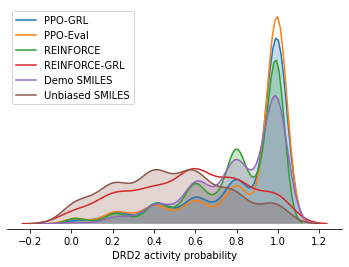

In [18]:
sns.kdeplot(preds_ppo_grl_smiles.ravel(), label='PPO-GRL', shade=True)#, color='blue')
sns.kdeplot(preds_ppo_baseline_reward_smiles.ravel(), label='PPO-Eval')#, shade=True, color='purple')
sns.kdeplot(preds_reinforce_smiles.ravel(), label='REINFORCE', shade=True)#, color='red')
ax = sns.kdeplot(preds_reinforce_grl_smiles.ravel(), label='REINFORCE-GRL')#, shade=True, color='orange')
sns.kdeplot(preds_demo_smiles.ravel(), label='Demo SMILES', shade=True)#, color='grey')
ax = sns.kdeplot(preds_unbiased_smiles.ravel(), label='Unbiased SMILES', shade=True)#, color='green')
plt.xlabel('DRD2 activity probability')
# ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# ax.set_xticks([])
sns.despine(offset=5, left=True, bottom=False)
plt.savefig('drd2/drd2_kde_plots.png')
plt.show()

## Convergence plot

In [19]:
ppo_grl_biased = ppo_grl_conv['biased']
ppo_baseline_reward_biased = ppo_baseline_reward_conv['biased']
reinforce_biased = reinforce_conv['biased']
reinforce_grl_biased = reinforce_grl_conv['biased']
demo_vals = reinforce_grl_conv['demo']
unbiased_vals = reinforce_grl_conv['baseline']

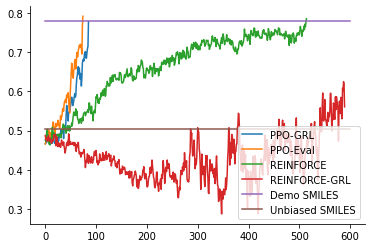

In [20]:
offset = 10
plt.plot(nbu.smoothing_values(ppo_grl_biased, 0.6)[offset:])
plt.plot(nbu.smoothing_values(ppo_baseline_reward_biased, 0.6)[offset:])
plt.plot(nbu.smoothing_values(reinforce_biased, 0.6)[offset:])
plt.plot(nbu.smoothing_values(reinforce_grl_biased, 0.6)[offset:])
plt.plot(demo_vals)
plt.plot(unbiased_vals)
plt.legend(['PPO-GRL','PPO-Eval','REINFORCE','REINFORCE-GRL', 'Demo SMILES', 'Unbiased SMILES'], loc='lower right')
# plt.savefig('logp_irl_vs_rl_convergence.png')
sns.despine()

## t-SNE plot

In [23]:
hparams = {'d_model': 1500,
            'dropout': 0.1919560782374305,
            'monte_carlo_N': 5,
            'use_monte_carlo_sim': True,
            'no_mc_fill_val': 0.0,
            'gamma': 0.97,
            'episodes_to_train': 12,
            'gae_lambda': 0.9228059180288825,
            'ppo_eps': 0.2,
            'ppo_batch': 1,
            'ppo_epochs': 6,
            'entropy_beta': 0.01,
            'use_true_reward': False,
            'baseline_reward': False,
            'reward_params': {'num_layers': 2, 'd_model': 172, 'unit_type': 'lstm', 'demo_batch_size': 128,
                              'irl_alg_num_iter': 3, 'use_attention': False, 'bidirectional': True,
                              'use_validity_flag': True,
                              'dropout': 0.3963193243801649, 'optimizer': 'sgd',
                              'optimizer__global__weight_decay': 0.010945638802254014,
                              'optimizer__global__lr': 0.000256177468757563},
            'agent_params': {'unit_type': 'gru', 'num_layers': 2, 'stack_width': 1500, 'stack_depth': 200,
                             'optimizer': 'adadelta', 'optimizer__global__weight_decay': 0.001428470680331549,
                             'optimizer__global__lr': 0.0008453447466167819},
            'critic_params': {'num_layers': 2, 'd_model': 256, 'unit_type': 'lstm', 'optimizer': 'adadelta',
                              'optimizer__global__weight_decay': 0.7424576981970683, 'dropout':0.,
                              'optimizer__global__lr': 0.0012980019737052746},
            'expert_model_params': {'model_dir': '../model_dir/expert_rnn_bin/',
                                    'd_model': 128,
                                    'rnn_num_layers': 2,
                                    'dropout': 0.8,
                                    'is_bidirectional': True,
                                    'unit_type': 'lstm'}
            }

In [48]:
init_dict = nbu.initialize(hparams, generators['demo_data'], generators['unbiased_data'], True)

In [50]:
encoder = init_dict['encoder']
ppo_reward_net_rnn = init_dict['reward_net_rnn']
ppo_reward_net = init_dict['reward_net']
ppo_reward_net.load_state_dict(nbu.load_model_weights('../model_dir/DRD2_activity_irelease_stack-rnn_gru_ppo_reward_net2020_07_09__23_58_24_0.778_96.mod'))

<All keys matched successfully>

In [59]:
with torch.set_grad_enabled(False):
    reward_lst, logits_lst = [], []
    tsne_smiles = ppo_grl_smiles_valid + ppo_grl_smiles_invalid
    for i in range(0, len(tsne_smiles), 500):
        inp, valid_vec = nbu.smiles_to_tensor(['<'+s+'>' for s in tsne_smiles[i:i+500]])
        enc_out = encoder([inp, valid_vec])
        reward, logits = ppo_reward_net_rnn(enc_out, return_logits=True)
        reward_lst.append(reward)
        logits_lst.append(logits)
    reward = torch.cat(reward_lst)
    logits = torch.cat(logits_lst)

In [60]:
logits.shape, reward.shape

(torch.Size([9967, 344]), torch.Size([9967, 1]))

In [108]:
tsne_rep = TSNE(n_components=2).fit_transform(logits.detach().cpu().numpy())
tsne_data = pd.DataFrame({'x':tsne_rep[:,0], 'y':tsne_rep[:,1]})
tsne_rep.shape

(9967, 2)

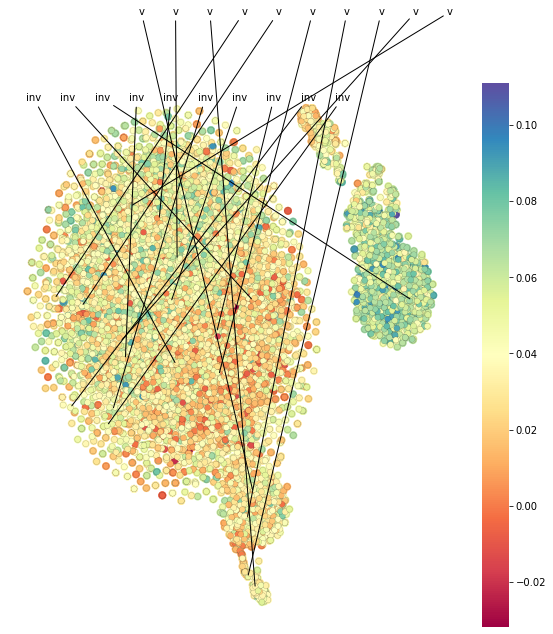

In [109]:
plt.figure(figsize=(10,10))
points = plt.scatter(tsne_data['x'], tsne_data['y'], c=reward.detach().cpu().numpy().reshape(-1,), s=50, cmap="Spectral")
cb = plt.colorbar(points, ticks=None)
cb.outline.set_visible(False)
ax = sns.scatterplot(x="x", y="y", hue=reward.detach().cpu().numpy().reshape(-1,), data=tsne_data, 
                    legend=False, palette='Spectral', edgecolor='black', linewidth=.1)
# valid SMILES
for i in range(10):
    va_idx = np.random.randint(len(ppo_grl_smiles_valid))
    ax.annotate('v', xy=(tsne_data['x'][va_idx], tsne_data['y'][va_idx]), 
                xytext=(-20+(i*10),70), 
                arrowprops=dict(facecolor='black', arrowstyle='-'),
               horizontalalignment='right', verticalalignment='top')

# invalid SMILES
for i in range(10):
    inv_idx = np.random.randint(len(ppo_grl_smiles_invalid))
    ax.annotate('inv', 
                xy=(tsne_data['x'][len(ppo_grl_smiles_valid) + inv_idx], 
                    tsne_data['y'][len(ppo_grl_smiles_valid) + inv_idx]), 
                xytext=(-50+(i*10),50), arrowprops=dict(facecolor='black', arrowstyle='-'),
               horizontalalignment='right', verticalalignment='top')

plt.axis('off')
plt.show()

##  Draw random SMILES

In [ ]:
generated_mols = [Chem.MolFromSmiles(sm, sanitize=True) for sm in set(unbiased_smiles)]
sanitized_gen_mols = [generated_mols[i] for i in np.where(np.array(generated_mols) != None)[0]]

In [ ]:
n_to_draw = 10
ind = np.random.randint(0, len(sanitized_gen_mols), n_to_draw)
mols_to_draw = [sanitized_gen_mols[i] for i in ind]
legends = ['p = ' + str(round(float(preds_ppo_grl_smiles[i]), 3)) for i in ind]
Draw.MolsToGridImage(mols_to_draw, molsPerRow=5, subImgSize=(300,300), legends=legends)

## Molecule metrics

## RNN hidden neurons examination